In [ ]:
"""環境"""
# .lab

"""更新履歴"""
# 最終更新日：2025/07/17
# 2025/07/17 inputsを保存するjsonを作ることにしました
# 2025/07/17 ctypesを使ってtkinterの解像度を上げることにしました
# 2025/05/21 shutilを使って、cachedirを洗浄することにしました
# 2025/05/15 simple_progress_barおよびdata(dict)を使い始めました。
# 2025/02/25 os.getcwd()を採用し、__file__を定義する必要をなくしました。

"""モジュール読み込み"""
# ファイル操作等
import sys
import os
# from datetime import datetime
from pprint import pprint
import logging
# import pickle
# import struct
from tqdm import tqdm
import h5py
# import threading
import json
import shutil

# tkinter
from tkinter import filedialog, messagebox, Tk
import ctypes
ctypes.windll.shcore.SetProcessDpiAwareness(1) # tkinterの解像度を上げる

# データ分析ツール
import pandas as pd
import numpy as np
import scipy as sp
# import math
# from sklearn.linear_model import LinearRegression

# グラフ等作成用
import matplotlib
import matplotlib.pyplot as plt         # 図の作成用
from PIL import Image as im
# import cv2
from IPython.display import display, HTML, clear_output, update_display, Image

# 自作モジュール
sys.path.append(r"C:\Users\okaza\pythonenv")
from modules.Mytools.Tools import print_fileinfo, h5_tree, dict_tree, simple_progress_bar, clean_cache_except_logfiles, get_total_size
import modules.Mytools.Settings
import modules.fitXRD as fx
from modules.peakfit import peakfit, pseudoVoigt

"""ログ管理ツール作成"""
# chche directoryの設定
cachedir = os.path.abspath(os.getcwd() + "/.cache")
clean_cache_except_logfiles(cachedir)
os.makedirs(cachedir, exist_ok=True)

# loggerの作成
logger = logging.getLogger(__name__)
logger.setLevel(logging.DEBUG)
format = "%(levelname)-9s  %(asctime)s [%(filename)s:%(lineno)d] %(message)s"

# Streamハンドラクラスを作成
sh = logging.StreamHandler()
sh.setLevel(logging.DEBUG)
sh.setFormatter(logging.Formatter(format))
logger.addHandler(sh)

# Fileハンドラクラスをインスタンス化
logfile = cachedir + ""
fh = logging.FileHandler(filename=cachedir + "/notebook.log", encoding="utf-8")
fh.setLevel(logging.DEBUG)
fh.setFormatter(logging.Formatter(format))
logger.addHandler(fh)
logger.debug("[Activate workspace]: " + os.getcwd())
logger.debug("[Set cache]: "+ os.path.abspath(cachedir))
logger.debug("[Activate log]: " + os.path.abspath(cachedir + "/notebook.log"))

# globalなデータを作成
data = dict()
logger.debug("[Create global variable]: data")

# inputをjsonファイルに保存する
data["inputs"] = os.path.join(cachedir, "input.json")
with open(data["inputs"], mode = "w") as f:
    json.dump(dict(), f)
logger.info("[Set json for save inputs]: " + os.path.abspath(data["inputs"]) )

DEBUG      2025-07-17 17:59:37,498 [3712578476.py:75] [Activate workspace]: c:\Users\okaza\pythonenv\fpd\png-mp4
DEBUG      2025-07-17 17:59:37,499 [3712578476.py:76] [Set cache]: c:\Users\okaza\pythonenv\fpd\png-mp4\.cache
DEBUG      2025-07-17 17:59:37,499 [3712578476.py:77] [Activate log]: c:\Users\okaza\pythonenv\fpd\png-mp4\.cache\notebook.log
DEBUG      2025-07-17 17:59:37,500 [3712578476.py:81] [Create global variable]: data
INFO       2025-07-17 17:59:37,502 [3712578476.py:87] [Set json for save inputs]: c:\Users\okaza\pythonenv\fpd\png-mp4\.cache\input.json


## 目的

フラットパネルのpng連続画像をmp4動画にします。

※ このノートブックの使用にはffmpegが必要です。

## 1. ファイルの読み込み

まずファイルリストを作成します。

表示されるダイアログからファイルを選択してください。  
なお、出力されるリストの順番で動画が生成されます。  
ファイルを選ぶ順番に気を付けてください。

In [4]:
def ask_filelist():

    if True: # ダイアログを開いて指定するのが面倒くさい場合はこちらを指定
        # ディレクトリ名を指定
        dir = r"C:\Users\okaza\OneDrive\画像\Screenshots"
        
        # ヘッダーとフッターを指定
        header = "UODE20_40_"
        footer = ".png"

        if True: # Main

            # inputの保存
            json_input = data["inputs"]
            with open(json_input, mode = "r") as f:
                inputs = json.load(f)
            key = sys._getframe().f_code.co_name
            inputs[key] = dict()
            inputs[key]["dir"] = dir
            inputs[key]["header"] = header
            inputs[key]["footer"] = footer
            with open(json_input, mode = "w") as f:
                json.dump(inputs, f, indent = 4)

            # ヘッダーとフッターを含むファイル名を取得
            filenames = list()
            for __ in os.listdir(dir):
                if not header in __:
                    continue
                if not footer in __:
                    continue
                filenames.append(os.path.join(dir, __))
            logger.debug("Filenames read")

            # ソート
            filenames.sort(key = (lambda x: int(os.path.basename(x).replace(header, "").replace(footer, ""))))
            logger.debug("File name list sorted")
        
    else:
        # tkinterでファイルダイアログを開く
        window = Tk()
        window.wm_attributes("-topmost", 1)
        window.withdraw()
        filenames = filedialog.askopenfilenames(
            parent = window,
            filetypes = [
                ("png", "*.png"),
            ]
        )

    # ファイルリストを表示する
    print(json.dumps(filenames, indent = 4))

    # 格納
    key = sys._getframe().f_code.co_name
    data[key] = dict()
    data[key]["flist"] = filenames
    data[key]["footer"] = ".png"
    logger.info("[Add variables]: " + key)
    dict_tree(data)

    return
ask_filelist()
del ask_filelist

DEBUG      2025-07-17 18:05:47,447 [1075581273.py:33] Filenames read
DEBUG      2025-07-17 18:05:47,447 [1075581273.py:37] File name list sorted
INFO       2025-07-17 18:05:47,448 [1075581273.py:59] [Add variables]: ask_filelist


[]

├── inputs <class 'str'>
└── ask_filelist
    ├── flist <class 'list'>
    └── footer <class 'str'>

画像を読み込みます。

In [ ]:
import threading
import concurrent.futures as confu

In [ ]:
def convertPNG2HDF():

    """更新履歴
    * 2025/07/17: ask_filelistを適用
    * 2025/06/25: 書き換え
    """

    # 読み込み終わったファイルがあればここを有効化し、ファイル名を指定する
    if True:

        # hdfファイル名
        hdffilename = ".cache/convertPNG2HDF.hdf"
        hdffilename = r"C:\Users\okaza\pythonenv\fpd\png_anim\.cache\convertPNG2HDF.hdf"
        logger.info("[Load pre-converted file]: " + os.path.abspath(hdffilename))

        # inputの保存
        json_input = data["inputs"]
        with open(json_input, mode = "r") as f:
            inputs = json.load(f)
        key = sys._getframe().f_code.co_name
        inputs[key] = dict()
        inputs[key]["hdffilename"] = os.path.abspath(hdffilename)
        with open(json_input, mode = "w") as f:
            json.dump(inputs, f, indent = 4)

    else:
        # 変数読み込み
        flist = data["ask_filelist"]["flist"]
        n_frame = len(flist)

        # hdfファイル初期化
        key = sys._getframe().f_code.co_name
        hdffilename = cachedir + "/" + key + ".hdf"
        tmpimage = np.array(im.open(flist[0]))
        with h5py.File(hdffilename, mode = "w") as f:
            for i in tqdm(range(n_frame)):
                f.create_dataset(
                    name = "frame = {}".format(i),
                    shape = tmpimage.shape,
                    dtype = tmpimage.dtype
                )
        logger.debug("hdf file initialized")
        
        # lock
        lock = threading.Lock()

        # 演算
        with confu.ThreadPoolExecutor(max_workers=os.cpu_count()) as tpe:
            
            # 演算開始
            futures = [
                tpe.submit(
                    lambda i: (i, np.array(im.open(flist[i]))),
                    i
                ) for i in range(n_frame)
            ]

            # 終わったプロセスから順に出力
            for i, future in enumerate(confu.as_completed(futures)):
                res = future.result()
                with lock:
                    j = res[0]
                    with h5py.File(hdffilename, mode = "r+") as f:
                        f["frame = {}".format(j)][:] = res[1] # type: ignore
                simple_progress_bar(i+1, n_frame)

    # 表示
    key = sys._getframe().f_code.co_name
    data[key] = dict()
    data[key]["hdf"] = hdffilename
    logger.info("[Add variables]: " + key)
    with h5py.File(hdffilename, mode = "r") as f:
        h5_tree(f)
    

    return
convertPNG2HDF()
del convertPNG2HDF

INFO       2025-07-17 18:08:34,418 [1290173295.py:14] [Load pre-converted file]: C:\Users\okaza\pythonenv\fpd\png_anim\.cache\convertPNG2HDF.hdf
INFO       2025-07-17 18:08:34,420 [1290173295.py:30] [Add variables]: convertPNG2HDF


<HDF5 file "convertPNG2HDF.hdf" (mode r)>
├── frame = 0 ((4096, 4096, 3), uint8)
├── frame = 1 ((4096, 4096, 3), uint8)
├── frame = 10 ((4096, 4096, 3), uint8)
├── frame = 100 ((4096, 4096, 3), uint8)
├── frame = 101 ((4096, 4096, 3), uint8)
├── frame = 102 ((4096, 4096, 3), uint8)
├── frame = 103 ((4096, 4096, 3), uint8)
├── frame = 104 ((4096, 4096, 3), uint8)
├── frame = 105 ((4096, 4096, 3), uint8)
├── frame = 106 ((4096, 4096, 3), uint8)
├── frame = 107 ((4096, 4096, 3), uint8)
├── frame = 108 ((4096, 4096, 3), uint8)
├── frame = 109 ((4096, 4096, 3), uint8)
├── frame = 11 ((4096, 4096, 3), uint8)
├── frame = 110 ((4096, 4096, 3), uint8)
├── frame = 111 ((4096, 4096, 3), uint8)
├── frame = 112 ((4096, 4096, 3), uint8)
├── frame = 113 ((4096, 4096, 3), uint8)
├── frame = 114 ((4096, 4096, 3), uint8)
├── frame = 115 ((4096, 4096, 3), uint8)
├── frame = 116 ((4096, 4096, 3), uint8)
├── frame = 117 ((4096, 4096, 3), uint8)
├── frame = 118 ((4096, 4096, 3), uint8)
├── frame = 119 ((409

## 2. 編集

トリミングを行います。

DEBUG      2025-07-18 09:21:33,296 [3873127136.py:29] Image loaded (shape = (4096, 4096, 3))
DEBUG      2025-07-18 09:21:33,395 [3873127136.py:62] [Save fig]: c:\Users\okaza\pythonenv\fpd\png-mp4\.cache\set_lim.png
INFO       2025-07-18 09:21:33,396 [3873127136.py:68] [Add variables]: set_lim


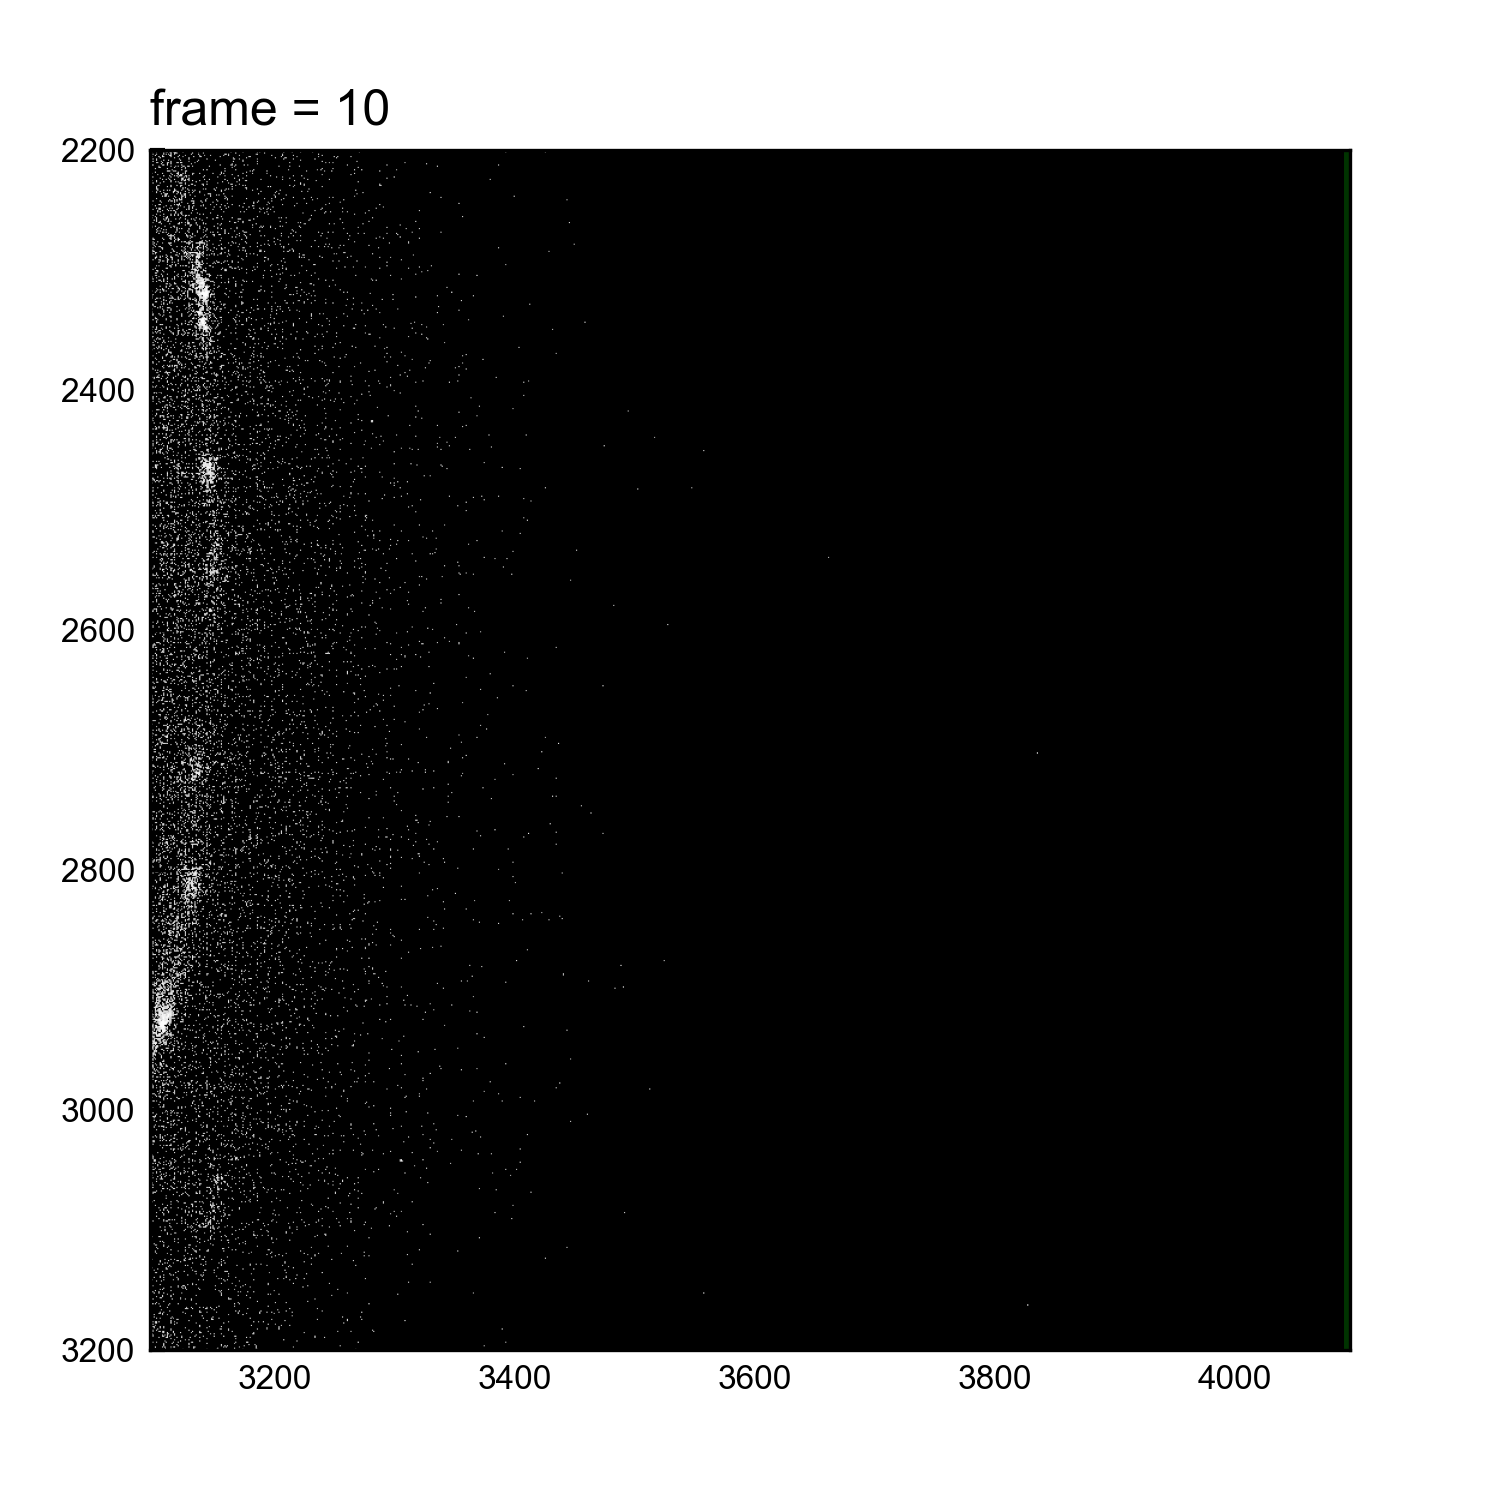


├── inputs <class 'str'>
├── ask_filelist
│   ├── flist <class 'list'>
│   └── footer <class 'str'>
├── convertPNG2HDF
│   └── hdf <class 'str'>
└── set_lim
    ├── x <class 'tuple'>
    └── y <class 'tuple'>

In [8]:
def set_lim():

    # フレーム番号
    framenumber = 10

    # 横軸
    xlim = (3096, 4096)

    # 縦軸
    ylim = (2200, 3200)

    if True: # Main
        
        # inputの保存
        json_input = data["inputs"]
        with open(json_input, mode = "r") as f:
            inputs = json.load(f)
        key = sys._getframe().f_code.co_name
        inputs[key] = dict()
        inputs[key]["framenumber"] = framenumber
        inputs[key]["xlim"] = xlim
        inputs[key]["ylim"] = ylim
        with open(json_input, mode = "w") as f:
            json.dump(inputs, f, indent = 4)

        # 画像読み込み
        with h5py.File(data["convertPNG2HDF"]["hdf"], mode = "r") as f:
            image: np.ndarray = f["frame = {}".format(framenumber)][()] # type: ignore
        logger.debug("Image loaded (shape = {})".format(image.shape))

        # figure作成
        fig, ax = plt.subplots()
        fig.set_size_inches((5,5)) # type: ignore
        fig.set_dpi(300)
        fig.subplots_adjust(
            left = 0.1,
            right = 0.9,
            bottom = 0.1,
            top = 0.9
        )

        # imshow
        ax.imshow(
            image[ylim[0]:ylim[1], xlim[0]:xlim[1]],
            extent = (*xlim, *(ylim[::-1])), # type: ignore
            aspect = "equal"
        )
        ax.set_title("frame = {}".format(framenumber), loc = "left", fontsize = 12)

        # 画像の表示
        fig.canvas.draw()
        img = im.frombuffer(
            mode = "RGBA",
            size = fig.canvas.get_width_height(),
            data = fig.canvas.buffer_rgba(), # type: ignore
            decoder_name = "raw"
        )
        plt.close()
        key = sys._getframe().f_code.co_name
        imgfilename = cachedir + "/{}.png".format(key)
        img.save(imgfilename)
        logger.debug("[Save fig]: " + os.path.abspath(imgfilename))

        # 格納
        data[key] = dict()
        data[key]["x"] = xlim
        data[key]["y"] = ylim
        logger.info("[Add variables]: " + key)

        # 出力
        display(Image(filename = imgfilename, width = 600))
        dict_tree(data)
    
    return
set_lim()
del set_lim

## 3. 出力

動画を作成します。

In [9]:
import matplotlib.animation as anim # type: ignore

In [10]:
def make_anim():

    # 変数の呼び出し
    xaxis = data["set_lim"]["x"]
    yaxis = data["set_lim"]["y"]
    logger.debug("Variables loaded")

    # figureの作成
    fig, ax = plt.subplots()
    fig.set_size_inches((5,5)) # type: ignore

    # 動画作成
    ims = []
    with h5py.File(data["convertPNG2HDF"]["hdf"], mode = "r") as f:
        n_frame = len(f.keys())
        for i in range(n_frame):
            image: np.ndarray = f["frame = {}".format(i)][()] # type: ignore
            image = ax.imshow(
                image[yaxis[0]:yaxis[1], xaxis[0]:xaxis[1]],
                extent = (*xaxis, *(yaxis[::-1])), # type: ignore
                aspect = "equal"
            )
            tex = ax.text(0,1.01, "frame number = {:>4}".format(i), fontsize = 12, transform = ax.transAxes)
            ims.append([image, tex])
            simple_progress_bar(i+1, n_frame)

    #. 保存
    logger.debug("[Save]: Animation")
    ani = anim.ArtistAnimation(fig, ims, interval = 100)
    key = sys._getframe().f_code.co_name
    filename = cachedir + "/" + key + ".mp4"
    logger.debug("Animation saving...")
    ani.save(filename, writer = "ffmpeg", fps = 30, dpi = 300)
    logger.info("[Save]: " + os.path.abspath(filename))
    plt.close()

    return
make_anim()
del make_anim

DEBUG      2025-07-18 09:21:47,627 [1905683667.py:6] Variables loaded


Progress: [■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■-] 100% (541/542) 

DEBUG      2025-07-18 09:22:09,801 [1905683667.py:28] [Save]: Animation
DEBUG      2025-07-18 09:22:09,802 [1905683667.py:32] Animation saving...


Progress: [■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■] 100% (542/542) 


INFO       2025-07-18 09:22:52,218 [1905683667.py:34] [Save]: c:\Users\okaza\pythonenv\fpd\png-mp4\.cache\make_anim.mp4


生成した動画を保存します。

生データごと保存する場合、同時にhtmlファイルをエクスポートすることも推奨します。  
このセルを動かす前にエクスポートすると、ディレクトリ保存で自動的にhtmlファイルも保存されます。

In [34]:
def save_data():
    
    # tkinterでファイルダイアログを開く
    window = Tk()
    window.wm_attributes("-topmost", 1)
    window.withdraw()
    filename = filedialog.asksaveasfilename(
        parent = window,
        filetypes = [
            ("mp4", "*.mp4"),
            ("hdf", "*.hdf"),
            ("json", "*.json"),
            ("DIRECTORY", "*.dir"),
        ],
        defaultextension=".mp4"
    )
    print(filename)
    

    # # 分岐
    if os.path.splitext(filename)[1] == ".mp4":
        original = os.path.join(cachedir, "make_anim.mp4")
        logger.debug("Original file being copied...: " + os.path.abspath(original))
        shutil.copy2(
            src = original,
            dst = filename
        )
        logger.info("File copied: " + os.path.abspath(filename))

    elif os.path.splitext(filename)[1] == ".hdf":
        original = data["convertPNG2HDF"]["hdf"]
        logger.debug("Original file being copied...: " + os.path.abspath(original))
        shutil.copy2(
            src = original,
            dst = filename
        )
        logger.info("File copied: " + os.path.abspath(filename))

    elif os.path.splitext(filename)[1] == ".json":
        original = data["inputs"]
        logger.debug("Original file being copied...: " + os.path.abspath(original))
        shutil.copy2(
            src = original,
            dst = filename
        )
        logger.info("File copied: " + os.path.abspath(filename))

    elif os.path.splitext(filename)[1] == ".dir":
        dirname = os.path.splitext(filename)[0]
        logger.debug("Original directory being copied...: " + os.path.abspath(os.getcwd()))
        shutil.copytree(
            src = os.getcwd(),
            dst = dirname,
            dirs_exist_ok = True
        )
        for f in os.listdir(dirname):
            if os.path.splitext(f)[1] == ".ipynb":
                os.remove(os.path.join(dirname, f))
        logger.info("Directory copied: " + os.path.abspath(dirname))

    return
save_data()
del save_data